# Desafio 7 - Classiﬁcação de tweets utilizando o BERT

## Objetivo

Utilizar um modelo pré-treinado de PLN (BERT) para classiﬁcar o
sentimento de tweets em positivo ou negativo.

### Preparação dos Dados:

- Utilize um conjunto de dados de avaliações de tweets rotulados com sentimento (positivo/negativo).
- Divida o conjunto de dados em conjuntos de treinamento e teste.

### Pré-processamento dos Dados:

- Limpeza e tokenização dos textos dos tweets.
- Codiﬁcação dos tokens utilizando o vocabulário do modelo BERT.
- Adição de tokens especiais para separar frases e indicar o início e ﬁm do texto.

### Fine-tuning do Modelo BERT:

- Carregue o modelo pré-treinado BERT.
- Adicione camadas adicionais para a classiﬁcação de sentimento.
- Deﬁna a função de perda e o otimizador.
- Treine o modelo utilizando o conjunto de treinamento.

### Avaliação do Modelo:

- Avalie o modelo utilizando o conjunto de teste.
- Calcule a precisão, recall, e outras métricas de avaliação.

### Aplicação do Modelo:

- Teste o modelo com tweets não vistos antes para veriﬁcar sua eﬁcácia na classiﬁcação de sentimentos.

## Importando os pacotes necessarios

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

## Carregando o dataset e salvando em uma variável

In [53]:
path = "./datasets/raw/Twitter_Data.csv"
df_twitter_raw = pd.read_csv(path, sep = ",")

## Informações sobre os dados contidos no dataset

### Valores aleatórios

In [54]:
df_twitter_raw.sample(5)

,clean_text,category
83548,when indias prime minister narendra modi annou...,1.0
92045,congratulations the award for getting the nare...,0.0
114306,sometimes think modi supporters are nuts stop ...,1.0
141121,defunct congress lined rejected film maker cri...,1.0
43230,you sow shall you reap you know you are going ...,1.0


### Informaçõees detalhadas

In [55]:
df_twitter_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


### Quantidade total de linhas do dataset

In [56]:
print(f"A quantidade total de linhas é: {df_twitter_raw.shape[0]}")

A quantidade total de linhas é: 162980


### EDA e Tratamento dos dados

### Tratamento dos dados

#### Copiando o dataset em nova variável para realizar os tratamentos de forma segura

In [57]:
df_twitter_processed = df_twitter_raw.copy(deep = True)
df_twitter_processed.sample(5)

,clean_text,category
104979,media was always alert thats why congress lost...,1.0
122297,ask this question modi will answer congress fa...,0.0
134159,one questioned modi wheres was known everyone ...,1.0
99767,should the government not respond critical iss...,1.0
26958,and modi never get elected again chamche,0.0


#### Renomeando as colunas

##### Verificando quais são as colunas contidas no dataset

In [58]:
df_twitter_processed.columns

Index(['clean_text', 'category'], dtype='object')

##### Realizando a renomeação

In [59]:
novas_colunas_nome = ["texto", "emocao"]
df_twitter_processed.columns = novas_colunas_nome
df_twitter_processed.sample(5)

,texto,emocao
6756,modi chokidar the nation and everybody well kn...,0.0
106922,waste time till criminal modi gugrat office,-1.0
151087,all seats except once files nomination from wa...,0.0
157301,thank you much honble fighter man sri narendra...,1.0
110240,two issues that will dominate the political di...,0.0


#### Alterando os valores da coluna "*emocao*"

##### Verificando os valores atuais

In [60]:
df_twitter_processed["emocao"].unique()

array([-1.,  0.,  1., nan])

Valores não-númericos/nulos foram achados, vamos tratar isso abaixo

##### Verificando os valores não-númericos/nulos na coluna "*emocao*"

In [61]:
df_twitter_processed["emocao"].isna().sum()

7

##### Verificando os valores não-númericos/nulos por todo o dataset

In [62]:
df_twitter_processed.isna().sum()

texto     4
emocao    7
dtype: int64

Como há somente 4 linhas faltantes da coluna "*texto*", será optado por excluir completamente as linhas

A quantidade de linhas excluidas não irá afetar muito a quantidades de dados do dataset

##### Excluindo as linhas onde há valores não-numéricos/nulos na coluna "*texto*"

In [63]:
df_twitter_processed = df_twitter_processed[~df_twitter_processed["texto"].isna()]

##### Nova contagem de valores não-numéricos/nulos

In [64]:
df_twitter_processed.isna().sum()

texto     0
emocao    7
dtype: int64

As linhas onde a coluna "*emocao*" possui valores nãp-numéricos/nulos não coincidio com a coluna "*texto*".

No entanto ainda será optado por excluir as linhas em questão, já que sua quantidade é muito pequena em comparação com o total do dataset

##### Excluindo as linhas onde há valores não-numéricos/nulos na coluna "*emocao*"

In [65]:
df_twitter_processed = df_twitter_processed[~df_twitter_processed["emocao"].isna()]

##### Nova contagem de valores não-numéricos/nulos

In [66]:
df_twitter_processed.isna().sum()

texto     0
emocao    0
dtype: int64

Agora vamos alterar os valores da coluna "*emocao*"

##### Realizando a alteração dos valores

In [67]:
dict_emocao_novos_valores = {
    -1 : 0, # NEGATIVO
    0 : 1,  # NEUTRO
    1 : 2   # POSITIVO
}

df_twitter_processed["emocao"] = df_twitter_processed["emocao"].map(dict_emocao_novos_valores)
df_twitter_processed["emocao"].unique()

array([0, 1, 2])

#### Alterando os tipos de dados contidos no dataset

Coluna *emocao*:
- Atual -> float64
- Novo -> uint8

Coluna *texto*:
- Atual -> Object
- Novo -> String

In [68]:
df_twitter_processed["emocao"] = df_twitter_processed["emocao"].astype("uint8")
df_twitter_processed["texto"] = df_twitter_processed["texto"].astype("string")

##### Verificando novos tipos

In [69]:
df_twitter_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   texto   162969 non-null  string
 1   emocao  162969 non-null  uint8 
dtypes: string(1), uint8(1)
memory usage: 2.6 MB


#### Salvando dataset atual em formato .pkl

In [70]:
path = "./datasets/processed/twitter_data.pkl"
df_twitter_processed.to_pickle(path)

### EDA

#### Quantidades unitárias de cada valor único da coluna "*emocao*"

In [71]:
df_twitter_processed["emocao"].value_counts()

emocao
2    72249
1    55211
0    35509
Name: count, dtype: int64

Podemos notar que:
- A maioria dos tweets é positivo, com o valor: 72249
- A quantidade de tweets neutros é de: 55211
- Os tweets negativos são a minoria, com o valor de: 35509

#### De forma gráfica

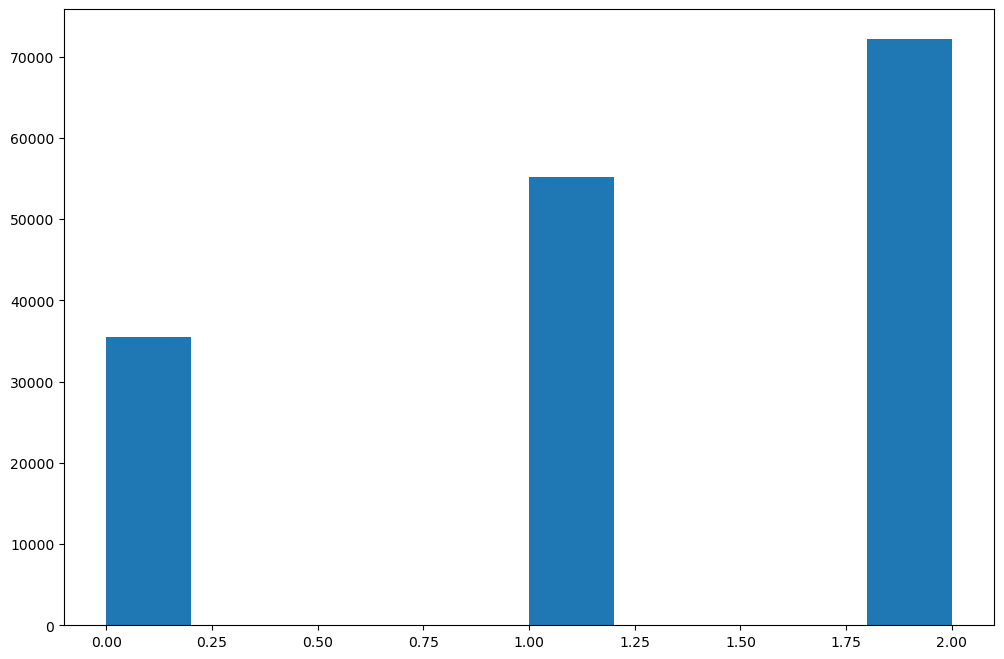

In [72]:
imagem = plt.figure(figsize=(12, 8))
plt.hist(x=df_twitter_processed["emocao"])
plt.show()

#### Desvio Padrão e Média Aritmética

In [73]:
print("O desvio padrão é de: ", df_twitter_processed["emocao"].std(),
    "\nA média aritmética é de: ", df_twitter_processed["emocao"].mean())

O desvio padrão é de:  0.7812794546501138 
A média aritmética é de:  1.225441648411661


#### Quantidade total de valores

In [74]:
print(f"{df_twitter_processed['emocao'].shape[0]} linhas")

162969 linhas


## Treinando o modelo BERT

### Separando o dataset em dados de entrada (X) e target (y)

In [75]:
X = df_twitter_processed.drop(columns = ["emocao"], axis = 1)
y = df_twitter_processed["emocao"]

### Realizando a separação de dados de teste e dados de treino

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Gerando Tokens através do texto

In [77]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#### Função para gerar e retornar os tokens através dos dados já separados

In [78]:
def tokenizar_texto(batch):
    return tokenizer\
        .batch_encode_plus(
            batch.tolist(),
            add_special_tokens = True,
            max_length = 512,
            return_tensors = "pt",
            padding = True,
            truncation = True,
        )


#### Gerando os tokens através de x_train e x_test

In [79]:
x_train = tokenizar_texto(x_train)
x_test = tokenizar_texto(x_test)

AttributeError: 'DataFrame' object has no attribute 'tolist'